In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting up kaggle and downloading the dataset
It will require a token file named 'kaggle.json' from kaggle.com to work.                                                           
[Tutorial to get token](https://www.kaggle.com/docs/api#authentication)                                                      
Acquire it and paste in the root of the files section on the left hand side to run this block.

In [7]:
! pip install kaggle

In [8]:
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download aladdinpersson/flickr8kimagescaptions

100% 1.04G/1.04G [00:07<00:00, 134MB/s]
100% 1.04G/1.04G [00:07<00:00, 144MB/s]


In [12]:
! unzip /content/flickr8kimagescaptions.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

### Importing Libraries

In [13]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
import spacy  
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image

### Model Architecture

In [3]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [5]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

### DataSet Preparation

In [14]:
spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [15]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [16]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [17]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [20]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),]
)

loader, dataset = get_loader(
    "flickr8k/images/", "flickr8k/captions.txt", transform=transform
)

for idx, (imgs, captions) in enumerate(loader):
    if idx%100==0: print(idx)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200


### Helper Functions

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

### Training

In [19]:
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="flickr8k/images",
        annotation_file="flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = True
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 10

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)
        print('epoch {}'.format(epoch))

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

Training the model 2 times for 10 epochs and saving the checkpoints due to not able to train for longer periods due to limited resources

In [60]:
train()

=> Loading checkpoint
epoch 0
=> Saving checkpoint


epoch 1
=> Saving checkpoint


epoch 2
=> Saving checkpoint


epoch 3
=> Saving checkpoint


epoch 4
=> Saving checkpoint


epoch 5
=> Saving checkpoint


epoch 6
=> Saving checkpoint


epoch 7
=> Saving checkpoint


epoch 8
=> Saving checkpoint


epoch 9
=> Saving checkpoint


Due to limited resources we can only train our model for 20 epochs, with more epochs its performance will surely increase.

### Demonstration

In [18]:
from matplotlib import pyplot as plt
import cv2

def show_img(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image, interpolation='nearest')
  plt.show()

def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    show_img('test_examples/dog.jpg')
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
    )

    test_img2 = transform(
        Image.open("test_examples/child.jpg").convert("RGB")
    ).unsqueeze(0)
    show_img('test_examples/child.jpg')
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
    )

    test_img3 = transform(Image.open("test_examples/bus.jpeg").convert("RGB")).unsqueeze(
        0
    )
    show_img('test_examples/bus.jpeg')
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
    )

    test_img4 = transform(
        Image.open("test_examples/boat.jpg").convert("RGB")
    ).unsqueeze(0)
    show_img('test_examples/boat.jpg')
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
    )

    test_img5 = transform(
        Image.open("test_examples/horse.jpg").convert("RGB")
    ).unsqueeze(0)
    show_img('test_examples/horse.jpg')
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
    )
    model.train()

=> Loading checkpoint


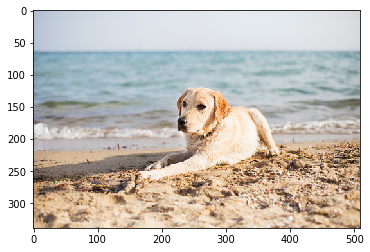

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>


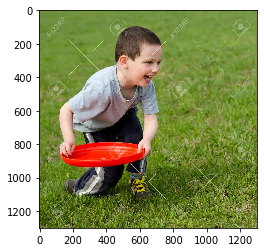

Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is running on a grassy field . <EOS>


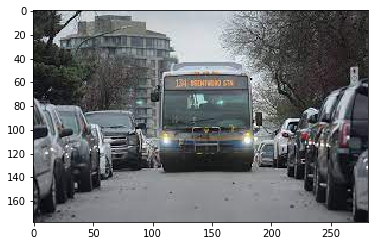

Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man is riding a bicycle down a road . <EOS>


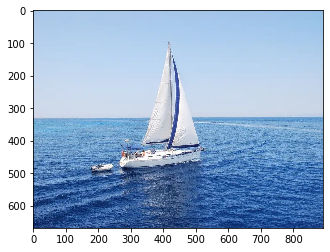

Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a cliff overlooking the ocean . <EOS>


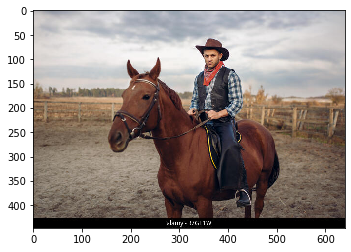

Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red jacket is standing on a hill with a dog . <EOS>


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 10
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)
print_examples(model,device,dataset)